In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/laurent/quantic/science/HomeHots/HOTS_clone_laurent/HOTS


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def makeve():
    x = torch.randint(0,34,[4000])
    y = torch.randint(0,34,[4000])
    p = torch.randint(0,1,[4000])
    t, ind = torch.randint(0,3000,[10000]).sort()
    t = torch.unique(t)
    n_events = len(t)
    x, y, p = x[:n_events, None], y[:n_events, None], p[:n_events, None]

    events = torch.cat([x,y,t[:, None],p],dim=1)
    x_index, y_index, t_index, p_index = 0, 1, 2, 3
    print(events.shape)
    return events, n_events, x_index, y_index, t_index, p_index

In [4]:
import tonic
download = False
eventset = tonic.datasets.NMNIST(save_to='../Data/',
                                  train=False, download=download,
                                  #transform=tonic.transforms.AERtoVector()
                                 )
loader = tonic.datasets.DataLoader(eventset, shuffle=True)

eventonic, target = next(iter(loader))
print(torch.squeeze(eventonic).shape, eventset.ordering)

torch.Size([3024, 4]) xytp


# Parameters

In [5]:
sample_space = 1
sample_events = 1
sensor_size = [34,34]
N_p = 2
tau = torch.tensor(1500)

In [6]:
sample_space = 1
sample_events = 1
sensor_size = [34,34]
N_p = 2
n_events = eventonic.shape[0]
tau = torch.tensor(1500)

x_index, y_index, t_index, p_index = 0, 1, 2, 3

switch_id = [0,1,3,2]

# With simple loop from get_data()

In [7]:
events, n_events, x_index, y_index, t_index, p_index = makeve()
print(events)

torch.Size([2908, 4])
tensor([[   9,    8,    0,    0],
        [  22,   25,    1,    0],
        [  20,   32,    2,    0],
        ...,
        [  10,    8, 2997,    0],
        [   5,   17, 2998,    0],
        [  12,   14, 2999,    0]])


In [8]:
%%timeit
events, n_events, x_index, y_index, t_index, p_index = makeve()

c_int = lambda n, d : ((n - 1) // d) + 1

data = torch.zeros((c_int(sensor_size[0],sample_space),
                     c_int(sensor_size[1],sample_space),
                     N_p))

X = np.zeros((c_int(n_events, sample_events), len(torch.flatten(data))))
    #y = np.zeros((c_int(n_events, sample_events), ))
for i_event in range(1, n_events):
    data *= torch.exp(-(events[i_event,t_index]-events[i_event-1,t_index])/tau)

    x_pos = events[i_event,x_index]//sample_space
    y_pos = events[i_event,y_index]//sample_space
    p = events[i_event,p_index]
    data[int(x_pos), int(y_pos), int(p)] = 1.

    if i_event % sample_events == sample_events//2:
        X[i_event//sample_events, :] = torch.flatten(data)

torch.Size([2898, 4])


RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

In [9]:
c_int = lambda n, d : ((n - 1) // d) + 1

data = torch.zeros((c_int(sensor_size[0],sample_space),
                     c_int(sensor_size[1],sample_space),
                     N_p))

X = np.zeros((c_int(n_events, sample_events), len(torch.flatten(data))))
    #y = np.zeros((c_int(n_events, sample_events), ))
for i_event in range(1, n_events):
    data *= torch.exp(-(events[i_event,t_index]-events[i_event-1,t_index])/tau)

    x_pos = events[i_event,x_index]//sample_space
    y_pos = events[i_event,y_index]//sample_space
    p = events[i_event,p_index]
    data[int(x_pos), int(y_pos), int(p)] = 1.

    if i_event % sample_events == sample_events//2:
        X[i_event//sample_events, :] = torch.flatten(data)

RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

(2908, 2312) torch.Size([2908, 4])


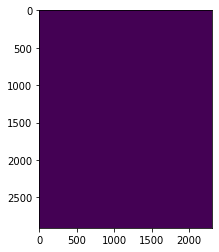

In [10]:
print(X.shape,events.shape)
plt.imshow(X)

In [11]:
events, n_events, x_index, y_index, t_index, p_index = makeve()
print(events[:,t_index])

torch.Size([2869, 4])
tensor([   0,    1,    2,  ..., 2997, 2998, 2999])


In [12]:
t = events[:,t_index].clone().detach()
events[:,2] = events[:,p_index]
events[:,3] = torch.arange(0,events.shape[0])
print(t, events)

tensor([   0,    1,    2,  ..., 2997, 2998, 2999]) tensor([[  16,   10,    0,    0],
        [  18,    6,    0,    1],
        [  13,   32,    0,    2],
        ...,
        [  19,   23,    0, 2866],
        [  13,   14,    0, 2867],
        [  29,   17,    0, 2868]])


torch.Size([2312, 2869])


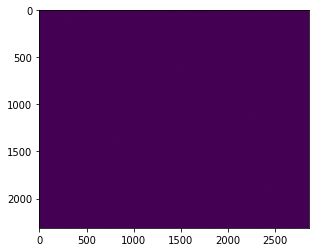

In [13]:
E = torch.ones(n_events)
R = torch.sparse.FloatTensor(events.T, E, torch.Size([34, 34, 2, n_events])).to_dense()
R = torch.flatten(R,0,2)
plt.imshow(R)
print(R.shape)

In [14]:
t_pos = 1000
A = torch.zeros([n_events,n_events])
T = torch.ones([t_pos,t_pos])
T = torch.triu(T)
print(T.shape)
A[-t_pos:,-t_pos:] = T

torch.Size([1000, 1000])


In [15]:
print(torch.matmul(A,t))

RuntimeError: expected scalar type Float but found Long

In [ ]:
print(E.shape, torch.sum(R))

<span style="color:red">**=======**</span>

In [ ]:
events, n_events, x_index, y_index, t_index, p_index = makeve()
print(events)

In [16]:
%%timeit
events, n_events, x_index, y_index, t_index, p_index = makeve()
t = events[:,t_index].clone().detach()
events[:,2] = events[:,p_index].clone().detach()
events[:,3] = torch.arange(0,events.shape[0])
p_index = 2

E = torch.ones(n_events)
R = torch.sparse.FloatTensor(events.T, E, torch.Size([34, 34, 2, n_events])).to_dense()
for i in range(len(t)):
    t_pos = t[i]
    dt = t_pos-t
    s = np.exp(dt/tau)
    s[s>1]=0
    #print(R.shape,events[i,p_index],p_index)
    R[events[i,x_index],events[i,y_index],events[i,p_index],:]+=s # /!\ de cette manière on cumule les évènements
R = torch.flatten(R,0,2)

torch.Size([2868, 4])


RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

In [17]:
print(torch.sum(R),len(t))

tensor(2869.) 2869


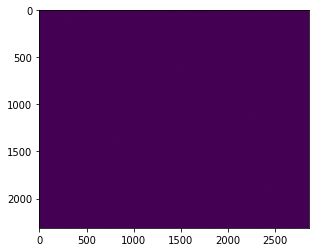

In [18]:
plt.imshow(R)

In [19]:
i = 10
M,N = R.shape
t_pos = t[i]

In [20]:
dt = t_pos-t
s = np.exp(dt/tau)
s[s>1]=0

RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

In [21]:
R[]

SyntaxError: invalid syntax (<ipython-input-21-0ca6c440224a>, line 1)

In [22]:
M,N = R.shape
t_pos = t[i]
a = np.ones([N-i,N-i])
a = np.triu(a)
b = np.zeros([i,i])
print(M,N,a.shape, b.shape)
A = np.concatenate([b,b])
B = np.concatenate([b,a])
C = np.concatenate([A.T,B.T])
print(C)
#print(np.triu(a))

2312 2869 (2859, 2859) (10, 10)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 2859

In [ ]:
t = np.array([1,10,11,20,25,30,30])
t2 = np.array([1,1,10,11,20,25,30])

In [ ]:
dt = t-t2
print(dt[:-1])

In [ ]:
dt2 = dt[:-1]
s = np.exp(-dt2)
print(s)

In [ ]:
M,N = 6,6
t_pos = 3
a = np.ones([M-t_pos,N-t_pos])
a = np.triu(a)
b = np.zeros([t_pos,t_pos])
A = np.concatenate([b,b])
B = np.concatenate([b,a])
C = np.concatenate([A.T,B.T])
print(C)
#print(np.triu(a))

In [ ]:
C@dt2